In [1]:
import sys
import subprocess
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seismic-library/')
import kaggle_support as kgs
import importlib
import time
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import cupy as cp
import copy
import seis_forward2

In [2]:
data = kgs.load_all_train_data(validation_only=True) + kgs.load_all_test_data()
data = data

In [3]:
folder = kgs.cache_dir_read + '/Style_A/'
#files_default = glob.glob(folder + '/*')
#files_default = ([os.path.basename(f) for f in files_default])
#files_default = set(files_default)
files_todo = ([os.path.basename(f) for f in glob.glob(folder + '/*')])
files_todo = set(files_todo)

In [4]:
def get_data_from_file(f):
    data = kgs.dill_load(f)[0]
    return data
res = dict()
res['cache_name'], res['is_train'], res['update_mae'], res['score_brendan'], res['score'], res['seis_err_rms'] = [],[],[],[],[],[]
for d in tqdm(data):
    f = d.cache_name()
    if f in files_todo:
        vel_default = get_data_from_file(folder +f)
        vel_brendan = get_data_from_file(kgs.cache_dir_read + '/brendan/' +f)
        res['cache_name'].append(f)
        res['is_train'].append(d.is_train)
        res['update_mae'].append(np.mean(np.abs(vel_default.data-vel_brendan.data)))
        if d.is_train:
            d.velocity.load_to_memory()
            res['score'].append(np.mean(np.abs(vel_default.data-cp.asnumpy(d.velocity.data))))
            res['score_brendan'].append(np.mean(np.abs(vel_brendan.data-cp.asnumpy(d.velocity.data))))
            d.velocity.unload()
        else:
            res['score'].append(np.nan)
            res['score_brendan'].append(np.nan)
        vel = copy.deepcopy(vel_default)
        vel.to_cupy()
        seis = kgs.Seismogram()
        seis.from_vector(seis_forward2.vel_to_seis(vel.to_vector())[0])
        d.seismogram.load_to_memory()
        res['seis_err_rms'].append(kgs.rms(seis.to_vector() - d.seismogram.to_vector()).get())
        d.seismogram.unload()
df = pd.DataFrame(res)
tr = df['is_train']
ntr = np.logical_not(df['is_train'])

  0%|          | 187/70818 [00:00<01:17, 914.71it/s]

capturing graph


100%|██████████| 70818/70818 [01:34<00:00, 749.60it/s]  


In [5]:
np.sum(df['is_train']), np.sum(np.logical_not(df['is_train'])), np.mean(df[tr]['score_brendan']), np.mean(df[tr]['score'])

(np.int64(502),
 np.int64(1237),
 np.float64(35.5750057266053),
 np.float64(5.611942738284275))

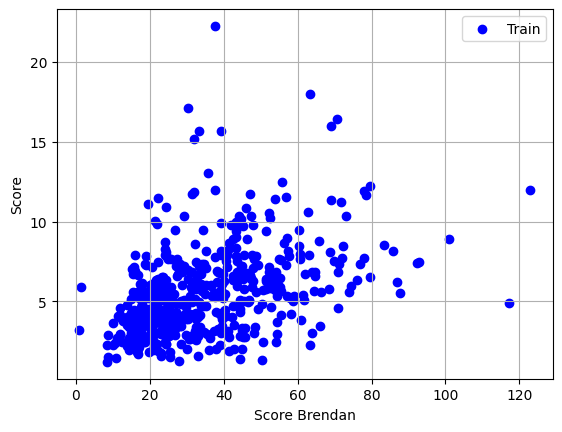

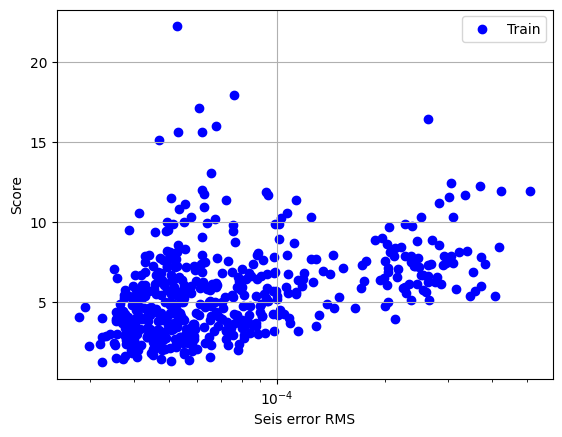

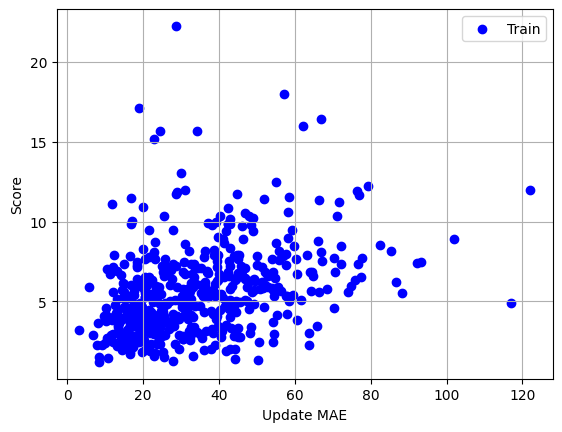

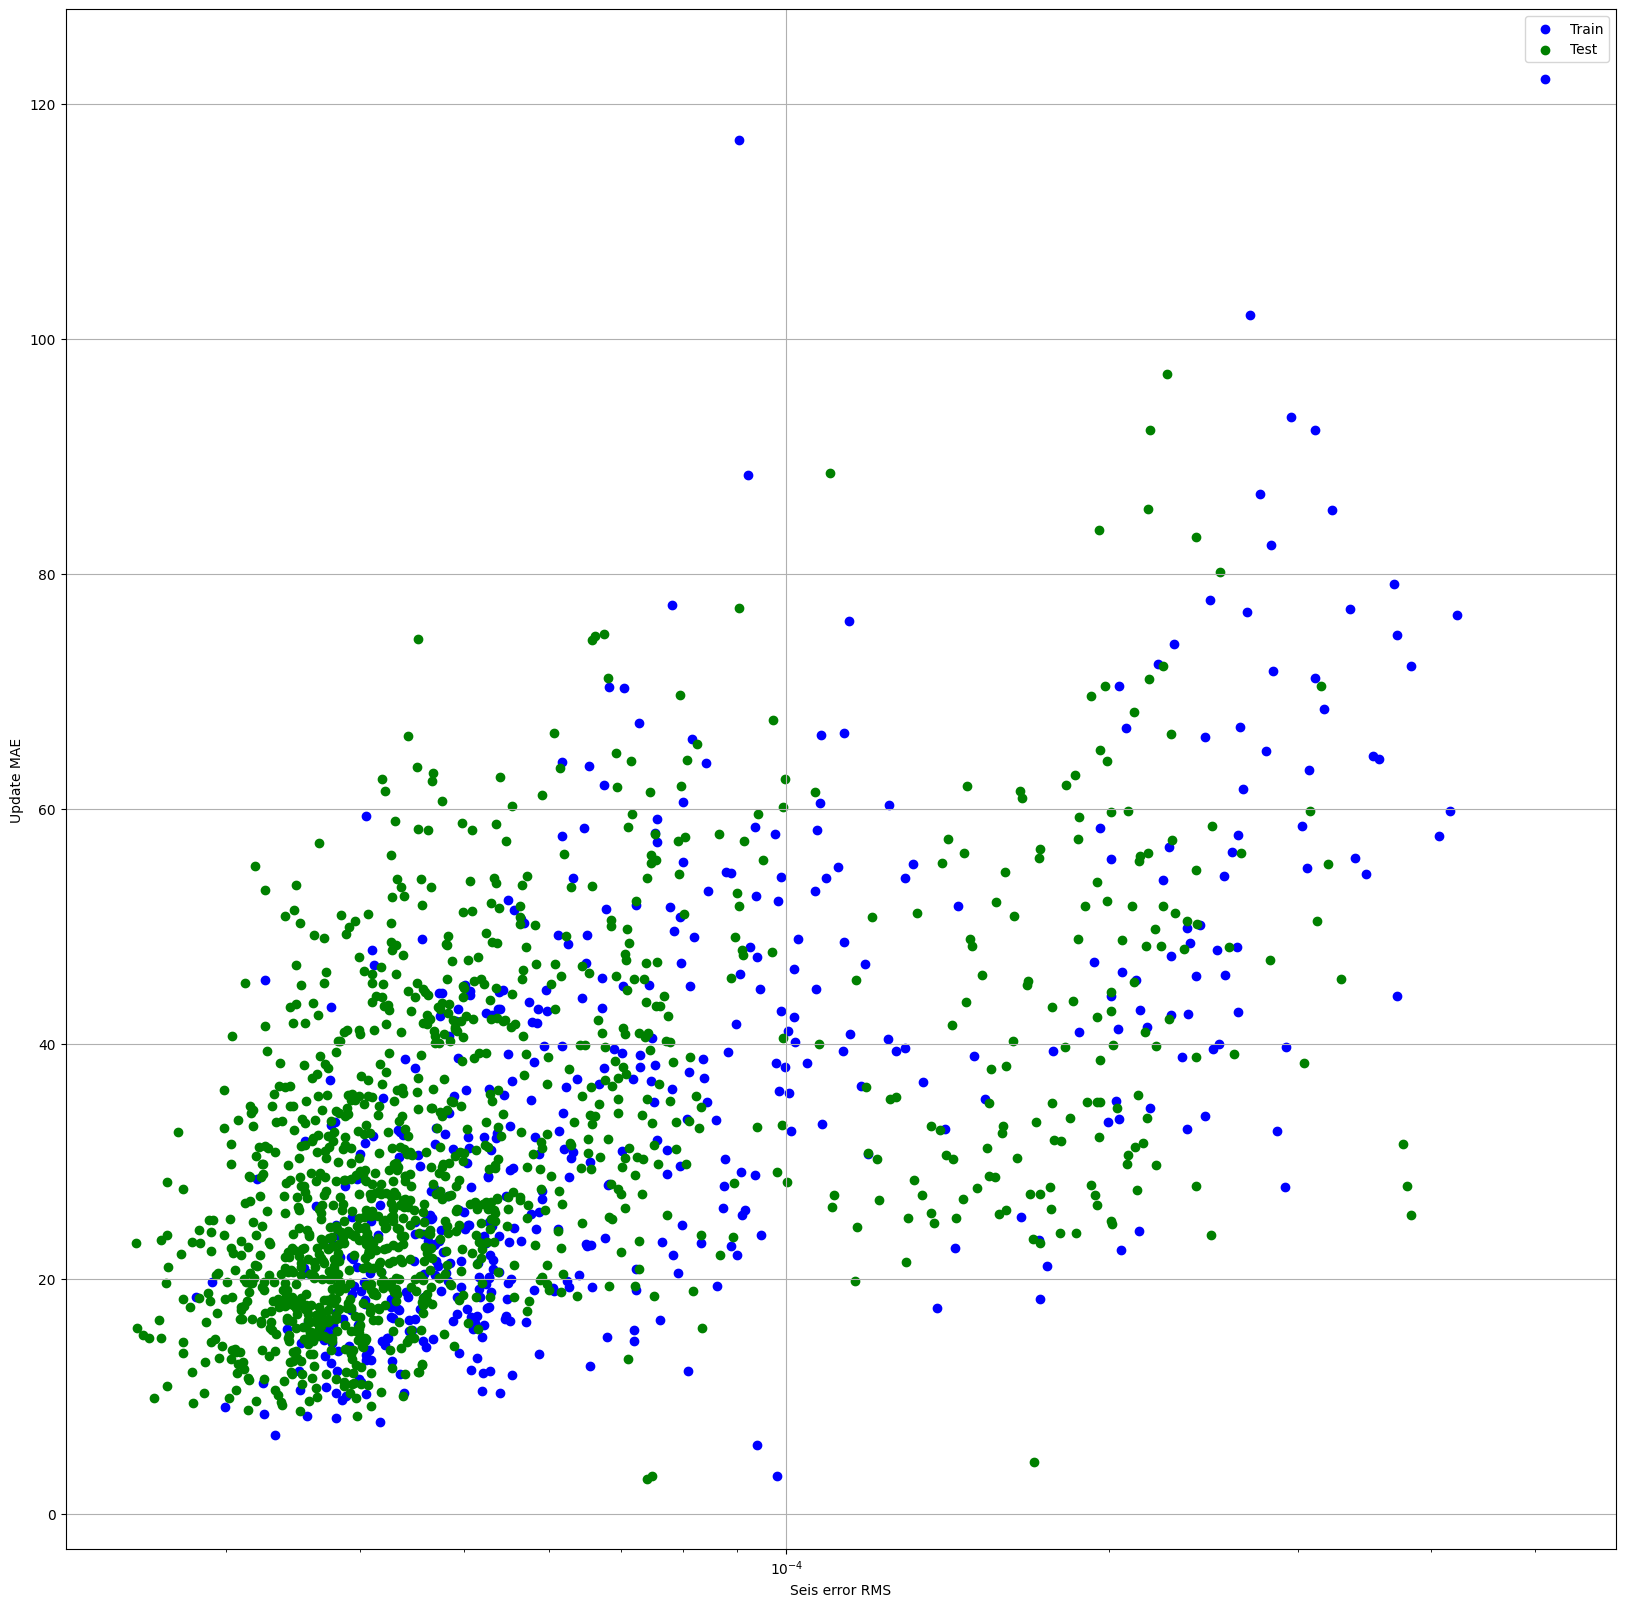

In [6]:
plt.figure();plt.scatter(df[tr]['score_brendan'],df[tr]['score'],color='blue');plt.xlabel('Score Brendan');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);
plt.figure();plt.scatter(df[tr]['seis_err_rms'],df[tr]['score'],color='blue');plt.xlabel('Seis error RMS');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);plt.xscale('log');
plt.figure();plt.scatter(df[tr]['update_mae'],df[tr]['score'],color='blue');plt.xlabel('Update MAE');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);

plt.figure(figsize=(20,20));plt.scatter(df[tr]['seis_err_rms'],df[tr]['update_mae'],color='blue');plt.scatter(df[ntr]['seis_err_rms'],df[ntr]['update_mae'],color='green');
plt.xlabel('Seis error RMS');plt.ylabel('Update MAE');plt.legend(('Train','Test'));plt.grid(True);plt.xscale('log');

(np.float64(122.0911846545504), np.float64(97.02187481475592))

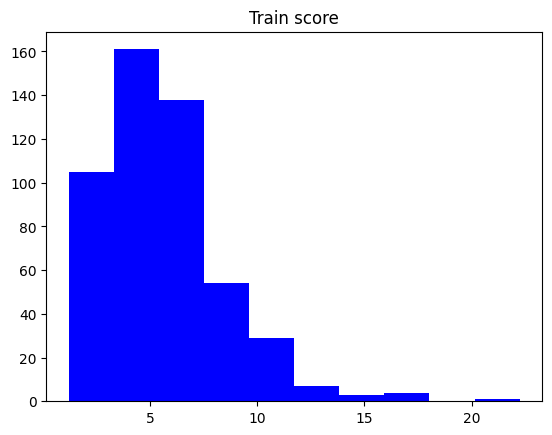

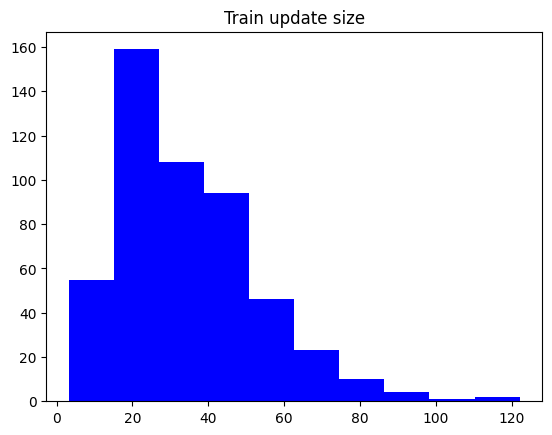

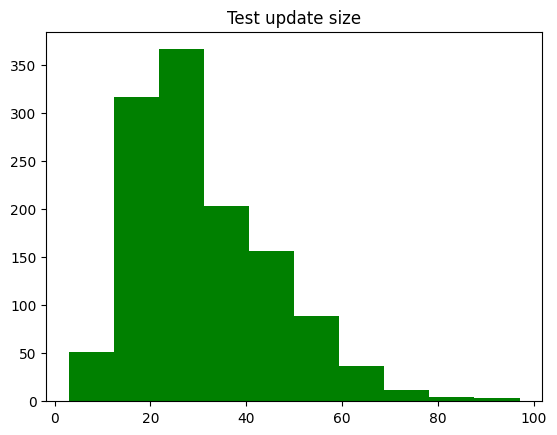

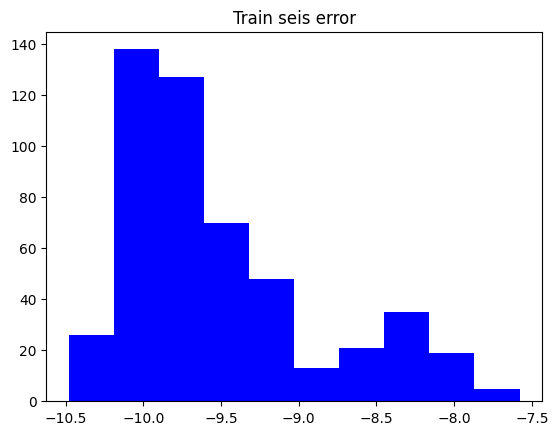

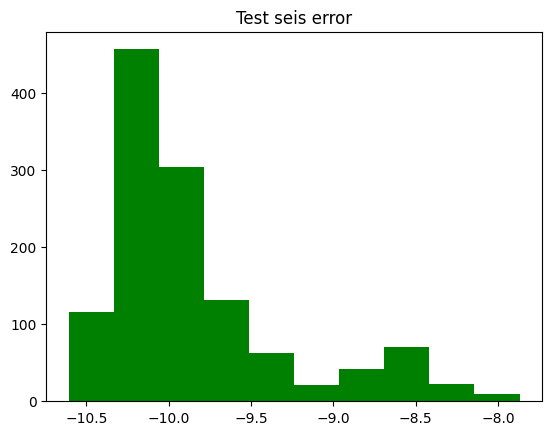

In [7]:
plt.figure();plt.hist(df[df['is_train']]['score'], color='blue');plt.title('Train score')
plt.figure();plt.hist(df[df['is_train']]['update_mae'], color='blue');plt.title('Train update size')
plt.figure();plt.hist(df[np.logical_not(df['is_train'])]['update_mae'], color='green');plt.title('Test update size')
plt.figure();plt.hist(np.log(np.array(list(df[df['is_train']]['seis_err_rms'].to_numpy()))), color='blue');plt.title('Train seis error')
plt.figure();plt.hist(np.log(np.array(list(df[ntr]['seis_err_rms'].to_numpy()))), color='green');plt.title('Test seis error')
np.max(df[tr]['update_mae']), np.max(df[ntr]['update_mae'])

62.0187175701316


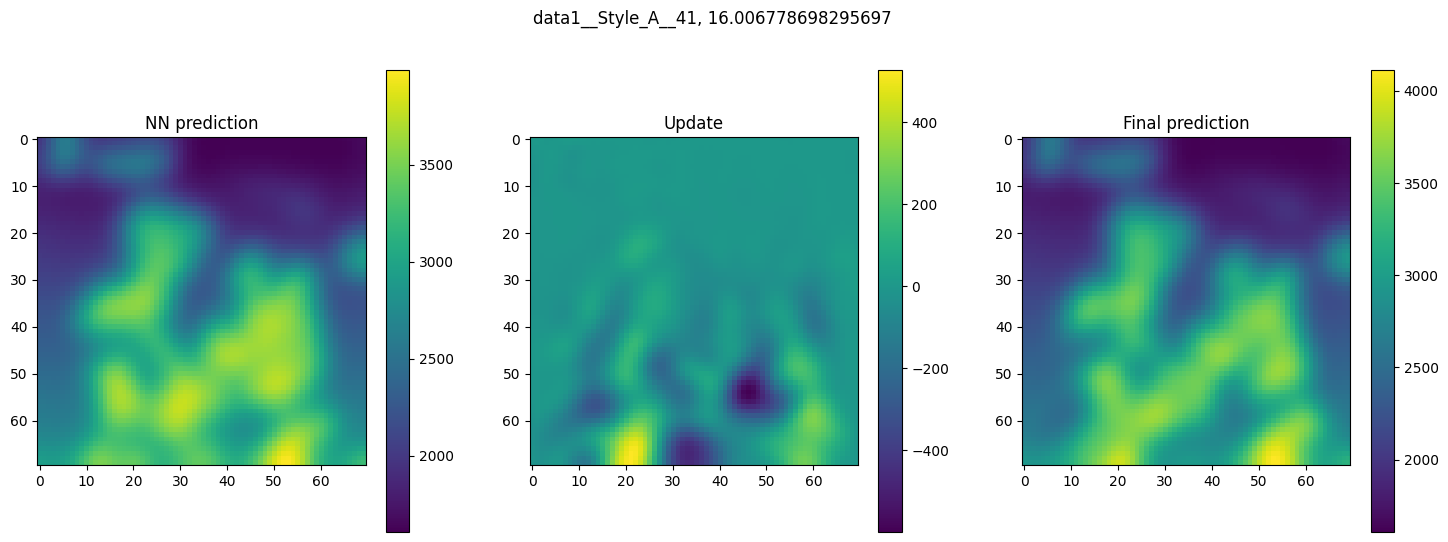

66.94429245892117


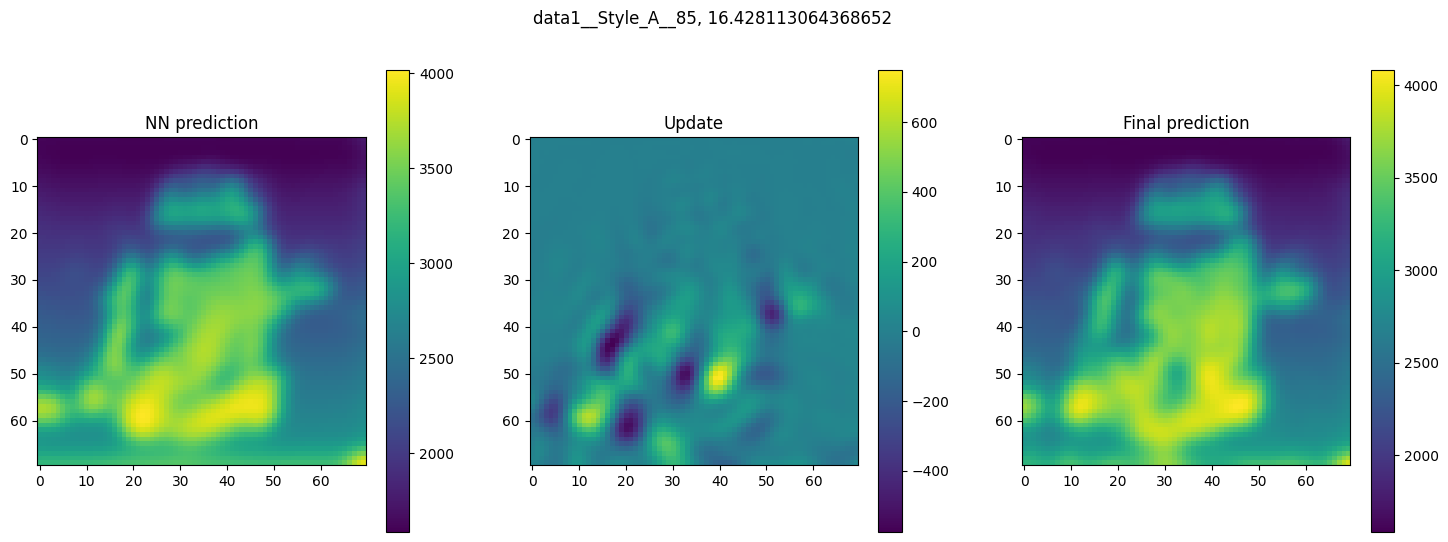

22.979388533550186


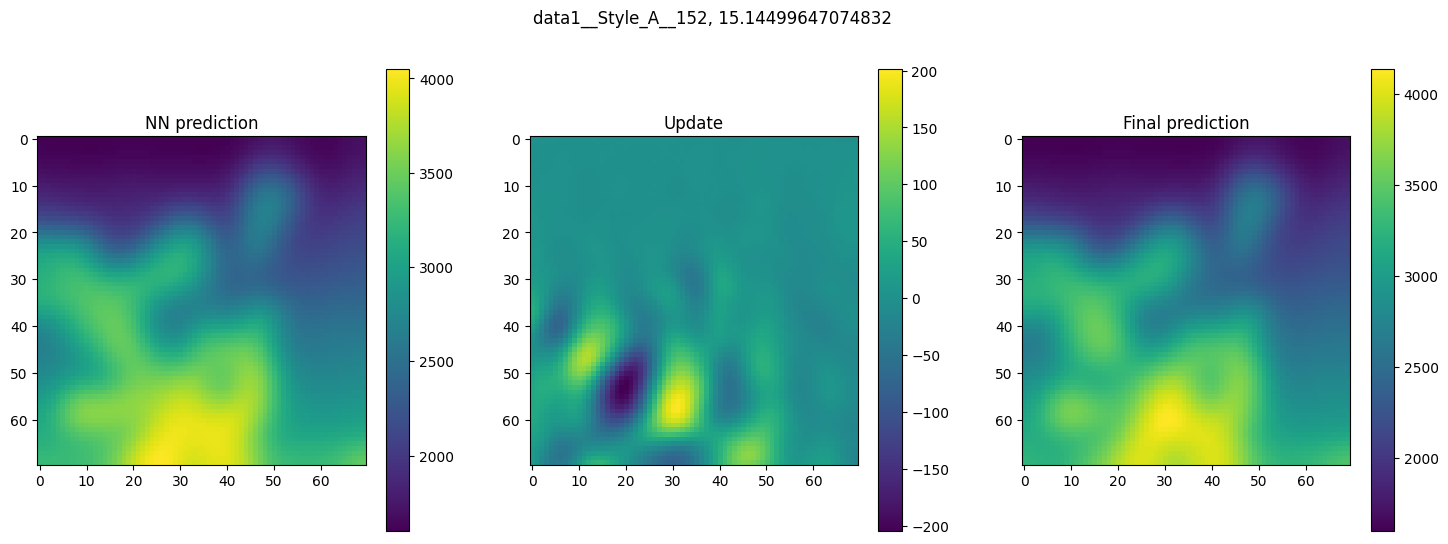

57.18619855398191


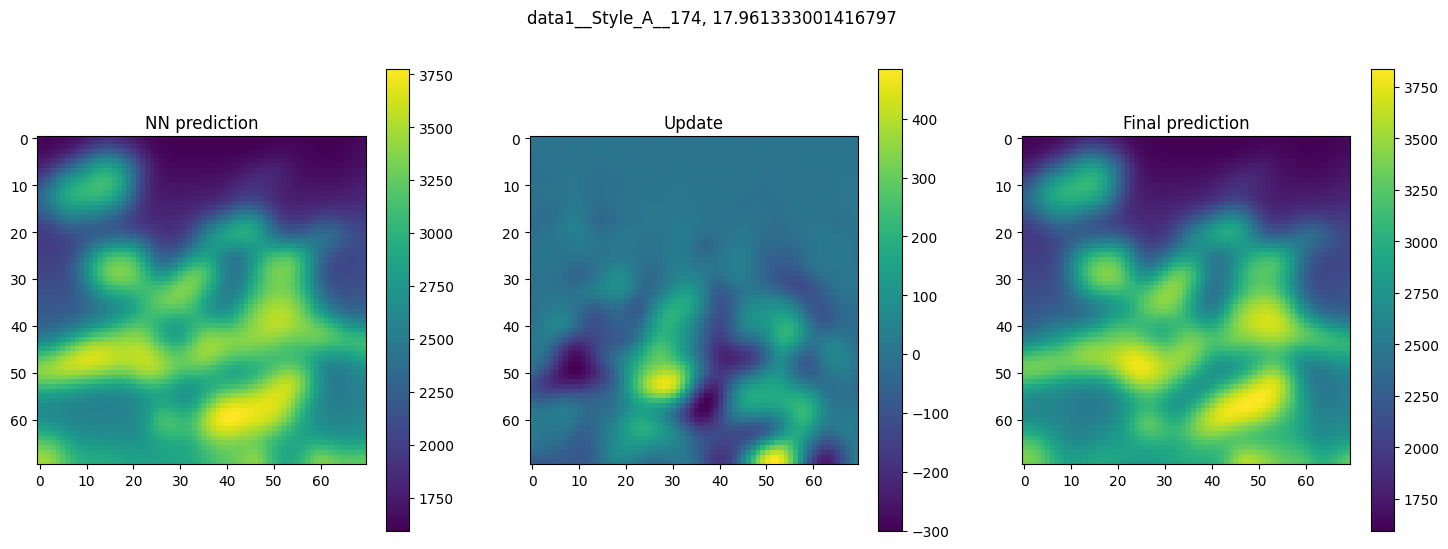

28.625344723026977


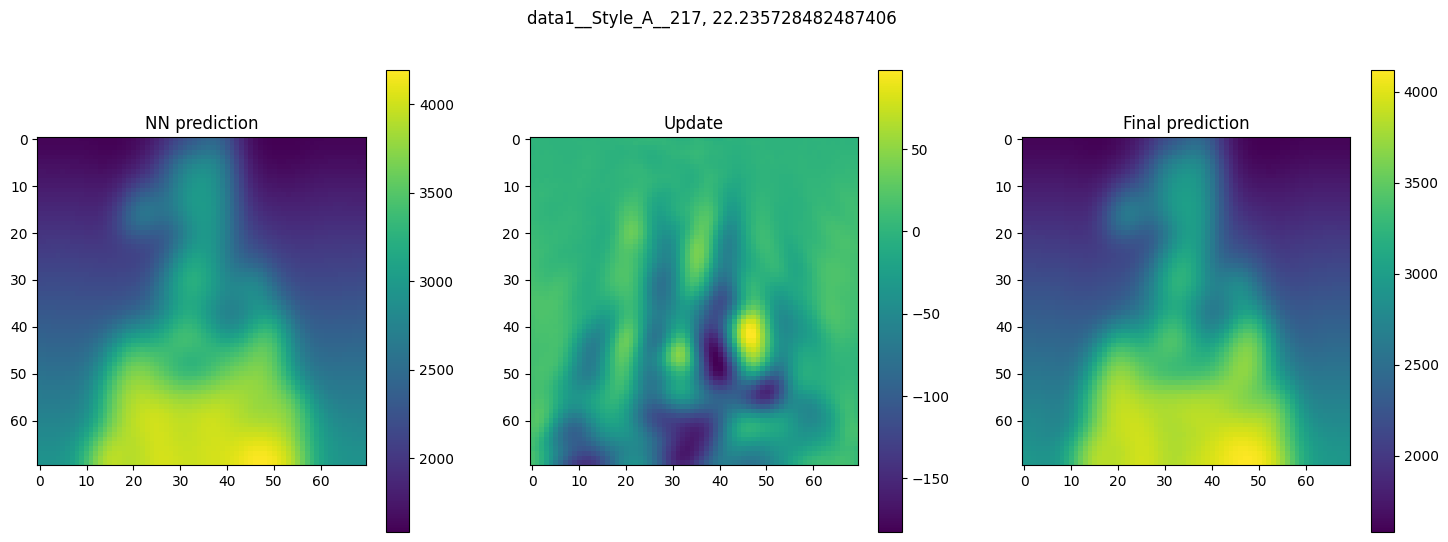

24.46193655385282


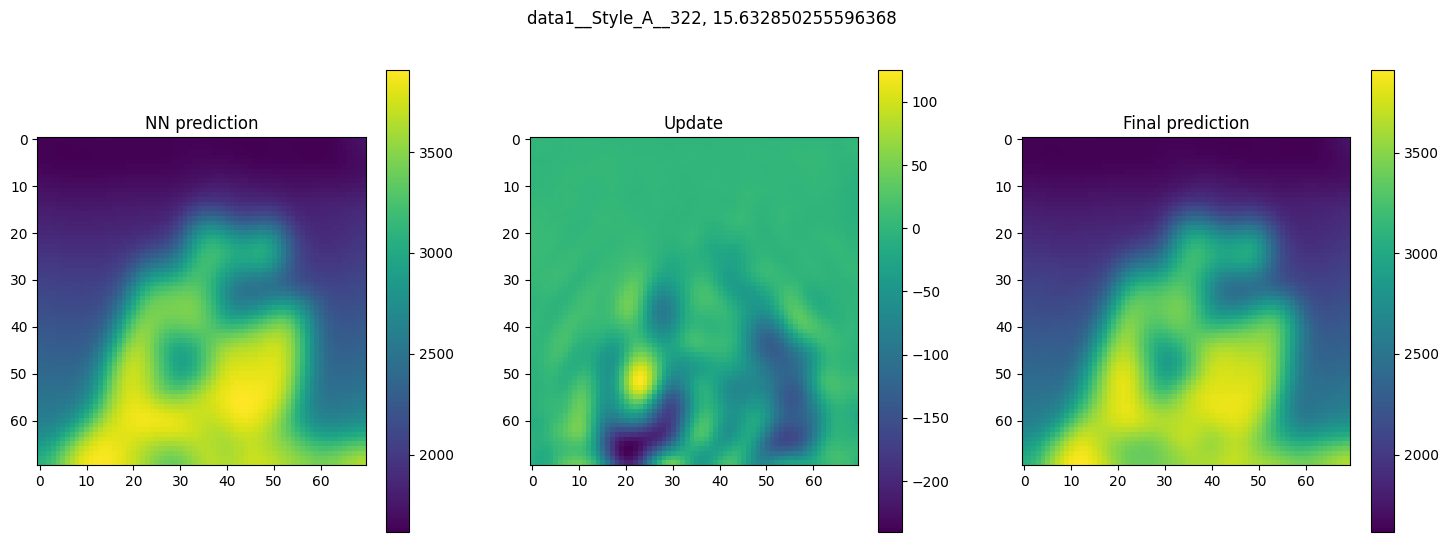

34.09811477939838


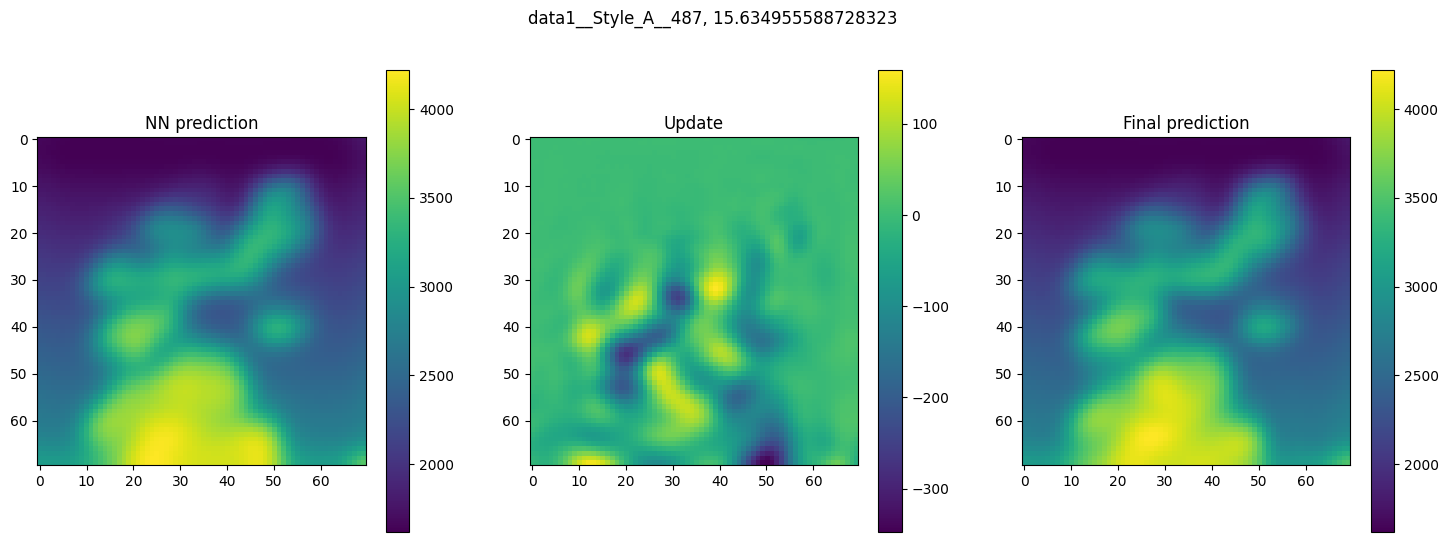

18.97343827603273


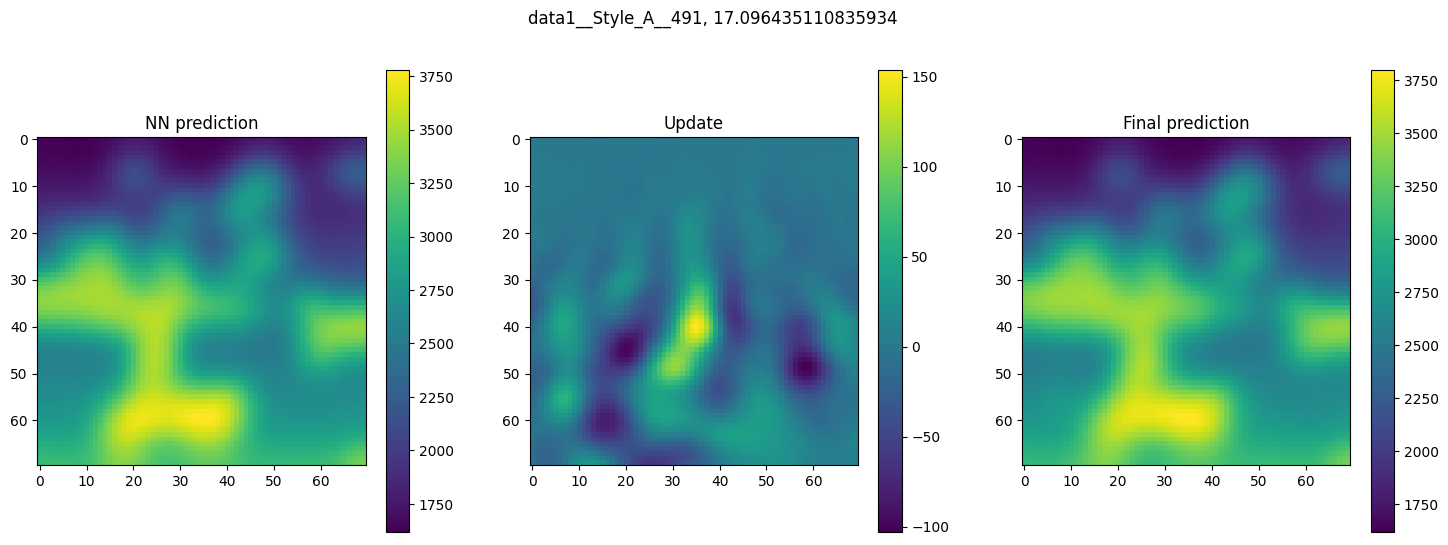

In [9]:
for _,row in df.iterrows():
    if row['score']>15:
        for d in data:
            if d.cache_name() == row['cache_name']:
                #print(d.cache_name());
                #if not 'Style_A' in d.family:
                #print(row)
                f=d.cache_name()
                vel_default = get_data_from_file(folder +f)
                vel_brendan = get_data_from_file(kgs.cache_dir_read + '/brendan/' +f)
                _,ax = plt.subplots(1,3,figsize=(18,6))
                plt.sca(ax[0]);plt.imshow(vel_brendan.data);plt.title('NN prediction');plt.colorbar()
                plt.sca(ax[2]);plt.imshow(vel_default.data);plt.title('Final prediction');plt.colorbar()
                plt.sca(ax[1]);plt.imshow(vel_default.data-vel_brendan.data);plt.title('Update');plt.colorbar()
                print(np.mean(np.abs(vel_default.data-vel_brendan.data)))
                plt.suptitle(f + ', ' + str(row['score']))
                plt.pause(0.001)
                